In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from modules import edge_detector_kernel, Conv2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Convolutions

Convolutions are a special kind of linear transformations. For each patch of neighboring pixels in an image, a convolution outputs a linear combination of the pixel values with the weights of the convolution filter *kernel*. Each of these outputs again represents a pixel value of the output image. One convolution kernel is of patch size $h \times w$. As we want one kernel for each input and output channel, the weights for a convolution layer are actually of size $C_{out} \times C_{in} \times h \times w$.

There are three properties which make convolutions very powerful:
- **parameter sharing:** The same parameters of the kernel are used in each patch of the image. This simplifies the model and additionally leads to a more faithful gradient on the weights.
- **locality:** The shape of the patches makes sure that we only use information from pixels located in a close neighborhood.
- **translational equivariance:** No matter, which patch we apply the convolution kernel to, the weights stay the same and therefore the behaviour is independent of the absolute position of the patch in the image. To be more precise, for any translation $\tau$ and input $x$, the convolution with kernel $k$ applied to the translation of $x$ is equal to the translation applied to the output of the convolution of $k$ and $x$, i.e. $\tau(x) * k = \tau(x * k)$.

# Cross-correlation vs. Convolutions

In the context of Deep Learning people often refer to discrete cross-correlation as convolutions. In PyTorch the `torch.nn.Conv2d` module takes inputs of the size $C_{\text{in}} \times H \times W$ and calculates the discrete ross-correlation w.r.t. a kernel of size $C_{\text{out}} \times C_{\text{in}} \times h \times w$ to produce an output of size $C_{\text{out}} \times H' \times W'$. In the case of no padding and no stride, the output size then amounts to $H' = H - (h - 1)$ and $W' = W - (w - 1)$ and the output values $z$ for input $x$ and kernel $k$ are calculated as
\begin{align}
z_{c, i, j} = \sum_{l=0}^{C_{\text{in}}-1} \sum_{m=0}^{h-1} \sum_{n=0}^{w-1} x_{l,i+m,j+n} \cdot k_{c,l,m,n}.
\end{align}
For the sake of notational simplicity we will use the term *'convolution'* in the following even though we actually mean cross-correlation.

# Convolutions as edge detectors [2 points]

Many low level image processing applications can be expressed as convolutions with fixed kernels. As an example, we now consider horizontal and vertical edge detectors for grayscale images. Assume we have an input grayscale image $u$ of size $1 \times 1 \times H \times W$. The edge detector is now supposed to calculate the derivative of the input image in $y$ direction in its first channel and the derivate in $x$ direction in its second channel. In order to approximate the derivates use finite differences, i.e. the the convolution output $v$ of size $1 \times 2 \times (H-1) \times (W-1)$ amounts to $v_{0, i, j} = u_{0, i+1, j} - u_{0, i, j}$ in the first channel and $v_{1, i, j} = u_{0, i, j+1} - u_{0, i, j}$ in the second channel for $i = 0, \ldots, H-1$, $j = 0, \ldots, W-1$. Modify the `edge_detector_kernel` in `modules.py` of size $2 \times 1 \times 2 \times 2$ and test you implementation by running the cells below.

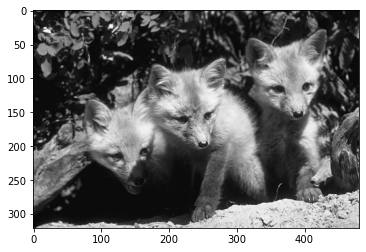

In [5]:
from torchvision.transforms.functional import to_tensor, to_grayscale
from PIL import Image
im_gray = to_tensor(to_grayscale(Image.open('foxes.png')))
im_gray = im_gray[None, ...]
plt.imshow(im_gray[0, 0], cmap='gray', vmin=0., vmax=1.)
plt.show()

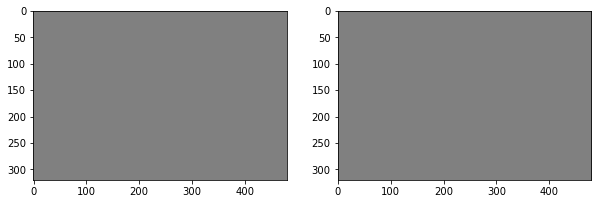

AssertionError: 

In [6]:
from modules import edge_detector_kernel

conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2, 2), bias=False)
conv.weight.data = edge_detector_kernel

with torch.no_grad():
    res = conv(im_gray)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(res[0, 0], cmap='gray', vmin=-0.5, vmax=0.5)
plt.subplot(1, 2, 2)
plt.imshow(res[0, 1], cmap='gray', vmin=-0.5, vmax=0.5)
plt.show()

assert (res[0, :, 100, 100] - torch.tensor([0.0235, 0.0353])).abs().max() < 1e-4

# Convolution implementation [6 points]

Implement a $2$-D convolution in `modules.py` and test your code below. First implement the padding operation in `ZeroPad2d`, then implement the strided convolution operation in `Conv2D`. For the sake of simplicity, you can expect your input to not have a batch dimension, i.e. the input is of size $C \times H \times W$. Do not use pre-implemented code for calculating convolutions.

In [7]:
torch.manual_seed(0)
x = torch.randn(1, 3, 6, 8)
kernel = torch.randn(2, 3, 4, 5)

conv = Conv2d(kernel, padding=1, stride=3)

conv_gt = nn.Conv2d(3, 2, (4, 5), padding=1, stride=3, bias=False)
conv_gt.weight.data = kernel

with torch.no_grad():
    res = conv(x[0])
    res_gt = conv_gt(x)[0]

assert (res_gt - res).abs().max() < 1e-5

TypeError: unsupported operand type(s) for -: 'Tensor' and 'NoneType'